# Toy Code for Group Equivariant CNNs

Writte by Wenhan Gao, Ph.D. student at Stony Brook University.

https://wenhangao21.github.io/

If you have any questions, feel free to reach out.



## Lifting Correlation Demonstration with $p_4$ Group

### Initialization and Helper functions

In [ ]:
from scipy.signal import convolve2d
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import camera
from skimage.color import rgb2gray

# Create an input 2D feature and a convolution kernel:
image = camera()[::8,::8]
rotation_multiple = 2 # rotation to the input image, multiples of 90 degrees, e.g. 2 means 180 deg
# Convolution kernel
conv_kernel = np.array([
    [50,  40,  30,  20,  10,   0,  -10],
    [40,  30,  20,  10,   0,  -10,  -20],
    [30,  20,  10,   0,  -10,  -20,  -30],
    [20,  10,   0,  -10,  -20,  -30,  -40],
    [10,   0,  -10,  -20,  -30,  -40,  -50],
    [ 0,  -10,  -20,  -30,  -40,  -50,  -60],
    [-10, -20,  -30,  -40,  -50,  -60,  -70]
])/50


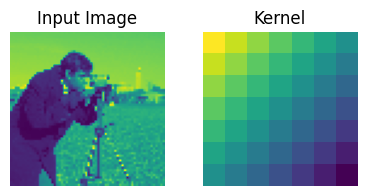

In [ ]:
# Plot the image and kernel
plt.figure(figsize=(4, 2))
plt.subplot(121)
plt.imshow(image)
plt.title('Input Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(conv_kernel, interpolation='nearest')
plt.title('Kernel')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_group_features(features):
    """
    Plot a series of features corresponding to 0°, 90°, 180°, and 270° rotations on the group space.

    Parameters:
    - features (list or numpy.ndarray): A list or 3D array of feature maps to be plotted.
    """
    titles = ['0°', '90°', '180°', '270°']  # Fixed titles for the four rotations
    plt.figure(figsize=(8, 2))
    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i + 1)
        plt.imshow(feature, cmap='viridis')  # Adjust colormap as needed
        plt.title(titles[i])
        plt.axis('off')  # Optional: Removes axis ticks
    plt.tight_layout()
    plt.show()


### $p_4$ Group

The $p_4$ group can be described as a semi-direct product:

$$
P_4=C_4 \ltimes \mathbb{Z}^2,
$$

where:
- $C_4$ : The cyclic group of order 4 representing the rotational symmetries.
- $\mathbb{Z}^2$ : The group of translations in the plane (not $\mathbb{R}^2$ because images are discrete).

### Lifting Correlation

$$
(k \star_{SE(2)} f)(x, \theta):=\int_{\mathbb{R}^2} k\Big(\mathbf{R}^{-1}_{\theta}(x'-x)\Big)f(x') d x'  = \int_{\mathbb{R}^2} [\mathscr{L}_{g=(x, \theta)}k(x')]f(x') d x' = \left\langle \mathscr{L}_{g=(x, \theta)}k, f \right\rangle_{\mathbb{L}_2\left(\mathbb{R}^2\right)}
$$

In [ ]:
def lift_correlation(image, kernel):
    """
    Apply lifting correlation/convolution on an image.

    Parameters:
    - image (numpy.ndarray): The input image as a 2D array, size (s,s)
    - conv_kernel (numpy.ndarray): The convolution kernel as a 2D array.

    Returns:
    - numpy.ndarray: Resulting feature maps after lifting correlation, size (|G|,s,s)
    """
    results = []
    for i in range(4):  # apply rotations to the kernel and convolve with the input
        rotated_kernel = np.rot90(conv_kernel, i)
        result = convolve2d(image, rotated_kernel, mode='same', boundary='symm')
        results.append(result)
    return np.array(results)

In [ ]:
features = lift_correlation(image, conv_kernel)

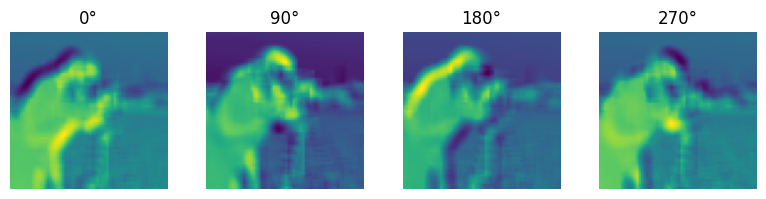

In [ ]:
plot_group_features(features)

3. Now, based on the math, a 90 deg rotation in the input image will result in a plannar 90 deg rotation + theta axis 90 deg rotation (shift):

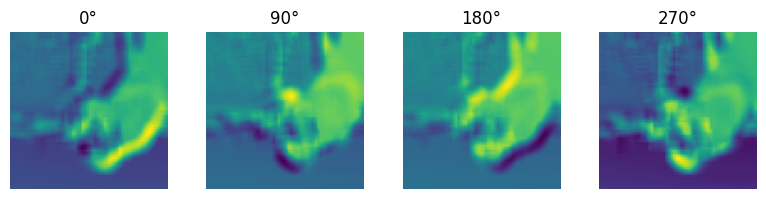

In [ ]:
# Plannar rotation + angular shift
features_shifted = np.empty_like(features)
# Peform angular shift
for i in range(4):
    shifted_index = (i + rotation_multiple) % 4
    features_shifted[shifted_index] = features[i]
features_shifted = np.rot90(features_shifted, rotation_multiple, axes=(1, 2)) # perform plannar rotation
plot_group_features(features_shifted)

4. Let's verify:

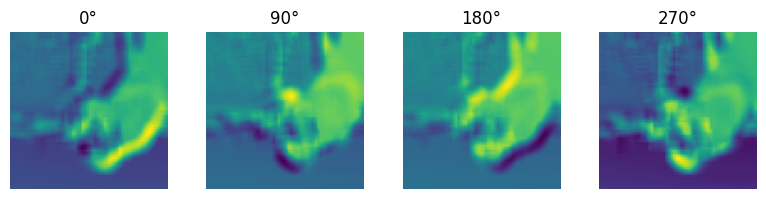

In [ ]:
# Plot the feature maps from the rotated input
image_rot = np.rot90(image, rotation_multiple)
features_rot = lift_correlation(image_rot, conv_kernel)
plot_group_features(features_rot)

5. Looks exactly the same, but let's do a sanity check

In [ ]:
if np.allclose(features_shifted, np.array(features_rot), atol=1e-8):
    print("The outputs are equivariant.")
else:
    print("The outputs are  not equivariant.")

The outputs are equivariant.


## Group Convolution Demonstration with $p_4$ Group

1. The inputs are now the feature maps defined in the group space (lifted to the group dimension)

In [ ]:
# Now the inputs will be the feature maps in the group space (angle, plannar x, plannar y)
print(features.shape)
print(features_rot.shape)

(4, 64, 64)
(4, 64, 64)


Feature maps from the original input


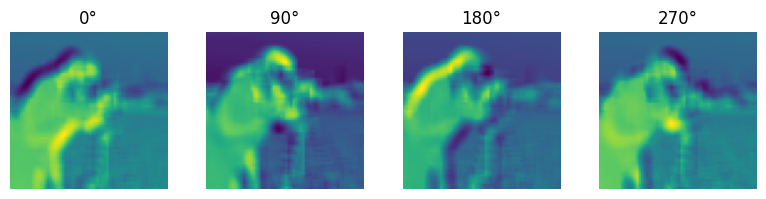

Feature maps from the rotated input


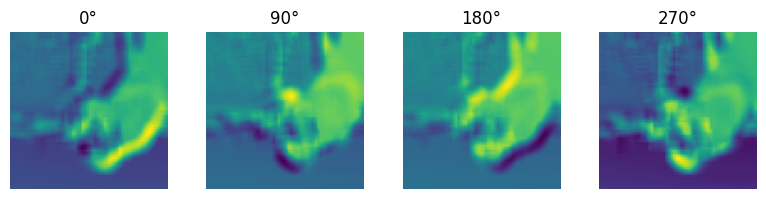

In [ ]:
print("Feature maps from the original input")
plot_group_features(features)
print("Feature maps from the rotated input")
plot_group_features(features_rot)

2. Perform Group Conv

In [ ]:
# A function to perform P4 group convolution with only 1 in_channel and 1 out_channel
def p4_group_convolution(features, kernel):
    """
    Perform P4 group convolution on a set of feature maps on P4 group.

    Parameters:
    - features (numpy.ndarray): A 3D array of feature maps with shape (|G|, s, s).
    - kernel (numpy.ndarray): A 2D array representing the convolution kernel.

    Returns:
    - numpy.ndarray: feature maps after the P4 group convolution with shape (|G|, s, s).
    """
    output = np.zeros_like(features)
    # Perform convolution for each feature map, convolve over both planar and angular axes
    for i in range(features.shape[0]):
        feature_map = features[i]
        result = np.zeros_like(feature_map)
        # SE(2) group on the kernels
        for j in range(4):
            rotated_kernel = np.rot90(kernel, j)
            result += convolve2d(feature_map, rotated_kernel, mode='same', boundary='symm')
        output[i] = result
    return output


In [ ]:
output_group_conv = p4_group_convolution(features, conv_kernel)
output_group_conv_rot = p4_group_convolution(features_rot, conv_kernel)

3. The results should still be equivariant, i.e., there is still a plannar rotation + an angular shift for the rotated original input cameraman.

Feature maps from the original input


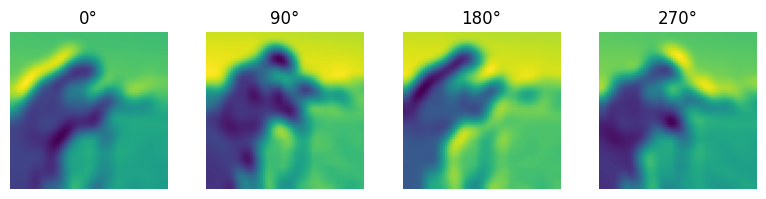

Feature maps from the rotated input


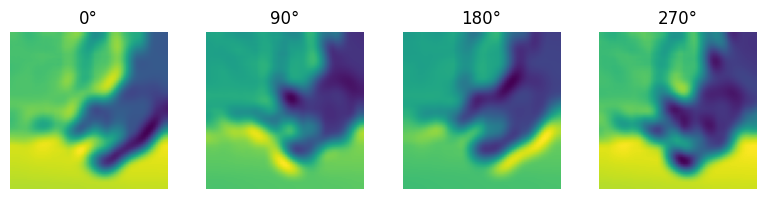

In [ ]:
print("Feature maps from the original input")
plot_group_features(output_group_conv)
print("Feature maps from the rotated input")
plot_group_features(output_group_conv_rot)

4. For the final output, we can do pooling over the angular axis (only plannar rotation left now)

In [ ]:
pooled_output = np.mean(output_group_conv, axis=0)
pooled_output_rot90 = np.mean(output_group_conv_rot, axis=0)

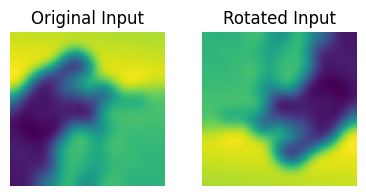

In [ ]:
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(pooled_output)
plt.title('Original Input')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(pooled_output_rot90)
plt.title('Rotated Input')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
if np.allclose(pooled_output_rot90, np.rot90(pooled_output, rotation_multiple)):
    print("The outputs are equivariant.")
else:
    print("The outputs are not equivariant.")

The outputs are equivariant.
